In [1]:
import os
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import util
import rans
from torch_vae import tvae_utils
from torchvision import datasets, transforms
import time
import matplotlib.pyplot as plt
from scipy.stats import norm, beta, binom
from scipy.special import gammaln
from torchvision.utils import save_image
from torch.distributions import Normal, Categorical, Beta, Binomial


In [2]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [3]:
rng = np.random.RandomState(0)
np.seterr(over='raise')

prior_precision = 8
obs_precision = 14
q_precision = 14

num_images = 100

compress_lengths = []

latent_dim = 50
latent_shape = (1, latent_dim)

In [4]:
class BetaBinomialVAE(nn.Module):
    def __init__(self, hidden_dim=200, latent_dim=50):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.register_buffer('prior_mean', torch.zeros(1))
        self.register_buffer('prior_std', torch.ones(1))
        self.register_buffer('n', torch.ones(100, 784) * 255.)

        self.fc1 = nn.Linear(784, self.hidden_dim)
        self.bn1 = nn.BatchNorm1d(self.hidden_dim)

        self.fc21 = nn.Linear(self.hidden_dim, self.latent_dim)
        self.fc22 = nn.Linear(self.hidden_dim, self.latent_dim)
        self.bn21 = nn.BatchNorm1d(self.latent_dim)
        self.bn22 = nn.BatchNorm1d(self.latent_dim)

        self.fc3 = nn.Linear(self.latent_dim, self.hidden_dim)
        self.bn3 = nn.BatchNorm1d(self.hidden_dim)
        self.fc4 = nn.Linear(self.hidden_dim, 784*2)
        self.sample_prior = False

    def encode(self, x):
        """Return mu, sigma on latent"""
        h = x / 255.  # otherwise we will have numerical issues
        h = F.relu(self.bn1(self.fc1(h)))
        return self.bn21(self.fc21(h)), torch.exp(self.bn22(self.fc22(h)))

    def reparameterize(self, mu, std):
        if self.training or self.sample_prior:
            print('sampling prior')
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h = F.relu(self.bn3(self.fc3(z)))
        h = self.fc4(h)
        log_alpha, log_beta = torch.split(h, 784, dim=1)
        return torch.exp(log_alpha), torch.exp(log_beta)

    def loss(self, x):
        z_mu, z_std = self.encode(x.view(-1, 784))
        z = self.reparameterize(z_mu, z_std)  # sample zs

        x_alpha, x_beta = self.decode(z)
        l = beta_binomial_log_pdf(x.view(-1, 784), self.n,
                                  x_alpha, x_beta)
        l = torch.sum(l, dim=1)
        p_z = torch.sum(Normal(self.prior_mean, self.prior_std).log_prob(z), dim=1)
        q_z = torch.sum(Normal(z_mu, z_std).log_prob(z), dim=1)
        return -torch.mean(l + p_z - q_z) * np.log2(np.e) / 784.

    def sample(self, device, epoch, num=64):
        sample = torch.randn(num, self.latent_dim).to(device)
        x_alpha, x_beta = self.decode(sample)
        beta = Beta(x_alpha, x_beta)
        p = beta.sample()
        binomial = Binomial(255, p)
        x_sample = binomial.sample()
        x_sample = x_sample.float() / 255.
        x_sample = x_sample.view(num, 1, 28, 28)
        save_image(x_sample,
                   'results/epoch_{}_samples.png'.format(epoch))
        return x_sample.squeeze().numpy()

    def reconstruct(self, x, device, epoch):
        x = x.view(-1, 784).float().to(device)
        z_mu, z_logvar = self.encode(x)
        z = self.reparameterize(z_mu, z_logvar)  # sample zs
        x_alpha, x_beta = self.decode(z)
        beta = Beta(x_alpha, x_beta)
        p = beta.sample()
        binomial = Binomial(255, p)
        x_recon = binomial.sample()
        x_recon = x_recon.float() / 255.
#         print(x.max(), x_recon.max())
        x_with_recon = torch.cat((x/255., x_recon))
        x_with_recon=x_with_recon.view(2, 1, 28, 28)
        save_image(x_with_recon,
                   'results/epoch_{}_recon.png'.format(epoch))
        return x_with_recon.squeeze().numpy()

In [5]:
model = BetaBinomialVAE(hidden_dim=200, latent_dim=latent_dim)
model.load_state_dict(
    torch.load('torch_vae/saved_params/torch_vae_beta_binomial_params',
               map_location=lambda storage, location: storage))
model.eval()

rec_net = tvae_utils.torch_fun_to_numpy_fun(model.encode)
gen_net = tvae_utils.torch_fun_to_numpy_fun(model.decode)

obs_append = tvae_utils.beta_binomial_obs_append(255, obs_precision)
obs_pop = tvae_utils.beta_binomial_obs_pop(255, obs_precision)

vae_append = util.vae_append(latent_shape, gen_net, rec_net, obs_append,
                             prior_precision, q_precision)
vae_pop = util.vae_pop(latent_shape, gen_net, rec_net, obs_pop,
                       prior_precision, q_precision)

In [6]:
# load some mnist images
num_images=64

mnist = datasets.MNIST('data/mnist', train=False, download=True,
                       transform=transforms.Compose([transforms.ToTensor()]))
images = mnist.test_data[:num_images]

images = [image.float().view(1, -1) for image in images]

# randomly generate some 'other' bits
other_bits = rng.randint(low=1 << 16, high=1 << 31, size=50, dtype=np.uint32)
state = rans.unflatten(other_bits)

/home/reasatt/miniconda3/envs/bb/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [7]:
prior_prec=8
latent_prec=12
std_gaussian_bucket_cache = {}  # Stores bucket endpoints
std_gaussian_centres_cache = {}  # Stores bucket centres

def gaussian_latent_cdf(mean, stdd, prior_prec, post_prec):
    def cdf(idx):
        x = std_gaussian_buckets(prior_prec)[idx]
        return _nearest_int(norm.cdf(x, mean, stdd) * (1 << post_prec))
    return cdf
def _nearest_int(arr):
    # This will break when vectorized
    return int(np.around(arr))

def std_gaussian_buckets(precision):
    """
    Return the endpoints of buckets partioning the domain of the prior. Each
    bucket has mass 1 / (1 << precision) under the prior.
    """
    if precision in std_gaussian_bucket_cache:
#         print(std_gaussian_bucket_cache)
        return std_gaussian_bucket_cache[precision]
    else:
        buckets = np.float32(
            norm.ppf(np.arange((1 << precision) + 1) / (1 << precision)))
        std_gaussian_bucket_cache[precision] = buckets
#         print(std_gaussian_bucket_cache)
        return buckets
def std_gaussian_centres(precision):
    """
    Return the centres of mass of buckets partioning the domain of the prior.
    Each bucket has mass 1 / (1 << precision) under the prior.
    """
    if precision in std_gaussian_centres_cache:
        return std_gaussian_centres_cache[precision]
    else:
        centres = np.float32(
            norm.ppf((np.arange(1 << precision) + 0.5) / (1 << precision)))
        std_gaussian_centres_cache[precision] = centres
        return centres
def gaussian_latent_ppf(mean, stdd, prior_prec, post_prec):
    def ppf(cf):
        x = norm.ppf((cf + 0.5) / (1 << post_prec), mean, stdd)
        # Binary search is faster than using the actual gaussian cdf for the
        # precisions we typically use, however the cdf is O(1) whereas search
        # is O(precision), so for high precision cdf will be faster.
        return np.searchsorted(
            std_gaussian_buckets(prior_prec), x, 'right') - 1
    return ppf


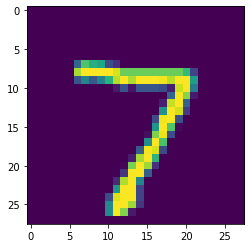

In [8]:
plt.imshow(images[0].reshape(28,28))

In [9]:
post_mean, post_stdd = rec_net(images[0])

In [10]:
z = model.reparameterize(post_mean,post_stdd)

In [11]:
z.shape

(1, 50)

<StemContainer object of 3 artists>

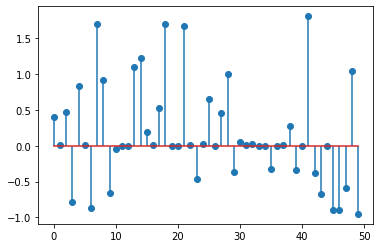

In [12]:
plt.stem(z.squeeze(),use_line_collection=True)

sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior


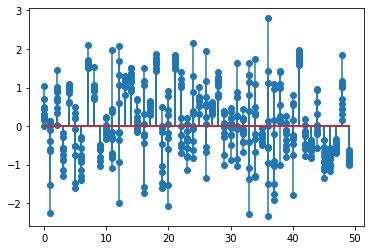

In [13]:
model.train()
for i in range(10):
    z = model.reparameterize(torch.tensor(post_mean), torch.tensor(post_stdd))
    plt.stem(z.squeeze(),use_line_collection=True)
plt.show()

In [14]:
z.shape

torch.Size([1, 50])

In [15]:
model.eval()
obs_params = gen_net(z)

In [16]:
np.array(obs_params).shape

(2, 1, 784)

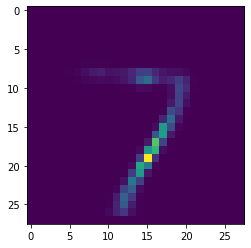

In [17]:
plt.imshow(obs_params[0][0].reshape(28,28))

In [18]:
from skimage.util import montage

# Sampling a single image distribution

sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior


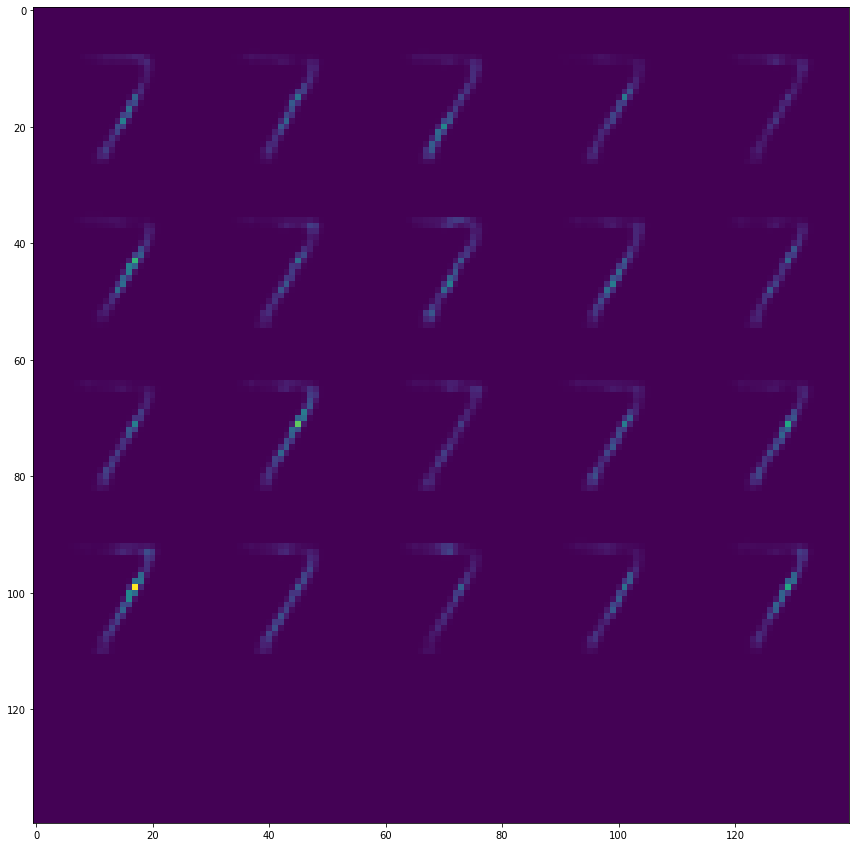

In [19]:
images_sweep = []
for i in range(20):
    model.train()
    z = model.reparameterize(torch.tensor(post_mean), torch.tensor(post_stdd))
    model.eval()
    obs_params = gen_net(z)
    images_sweep.append(obs_params[0][0].reshape(28,28))
#     plt.imshow(obs_params[0][0].reshape(28,28))
#     plt.show()
plt.figure(figsize=(15,15))
plt.imshow(montage(images_sweep))

# Randomly sampling the decoder

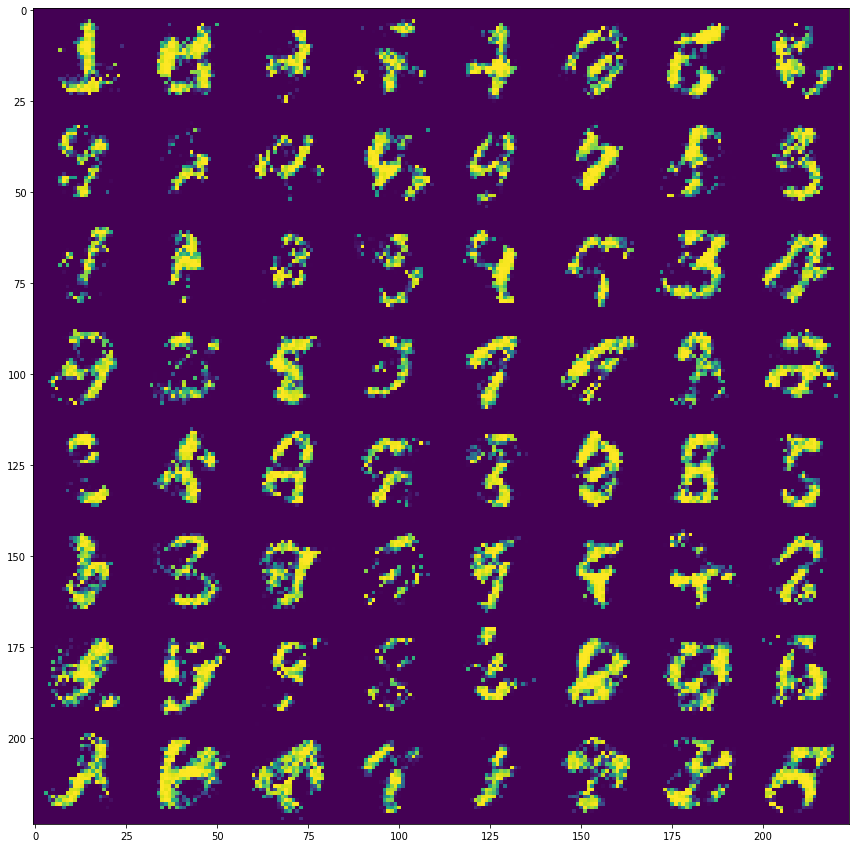

In [20]:
model.eval()
img_gen = model.sample(device,epoch='last')
plt.figure(figsize=(15,15))
plt.imshow(montage(img_gen))

# Reconstruction

If model.eval(),  mean of the prior distribution is used. If model.train(), prior distribution is sampled. In each case the likelihood distribution is always sampled.

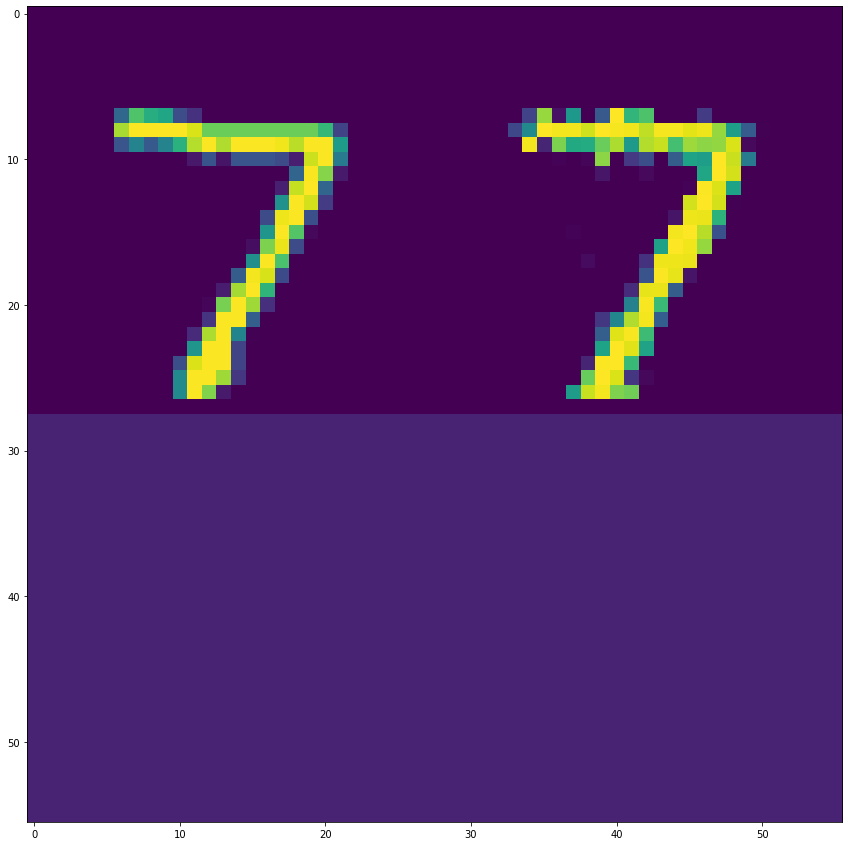

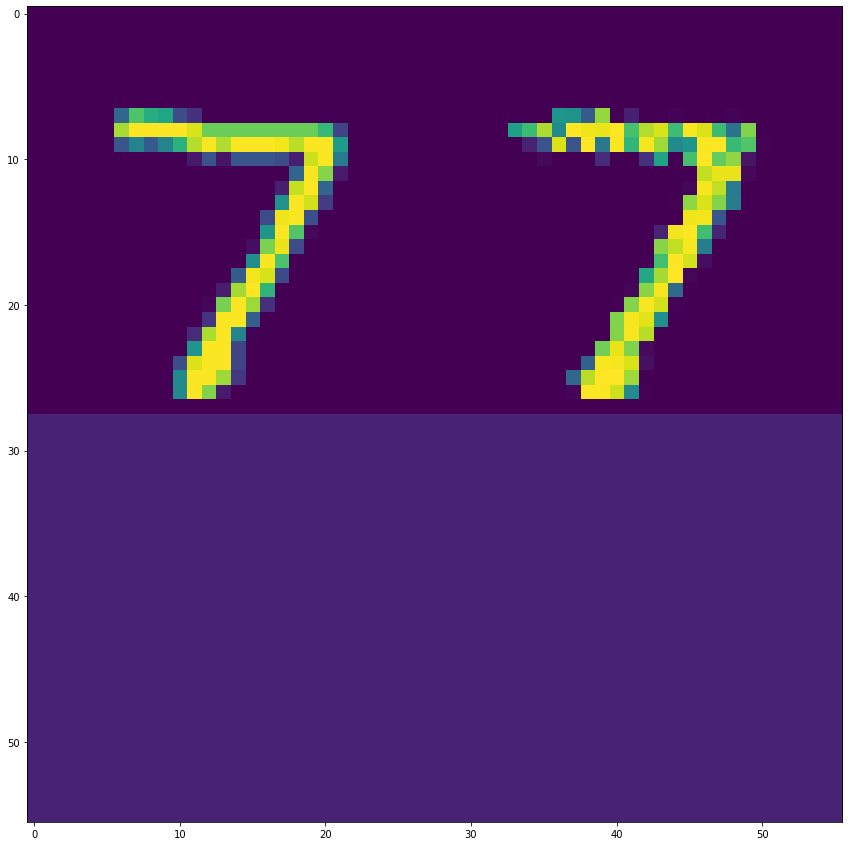

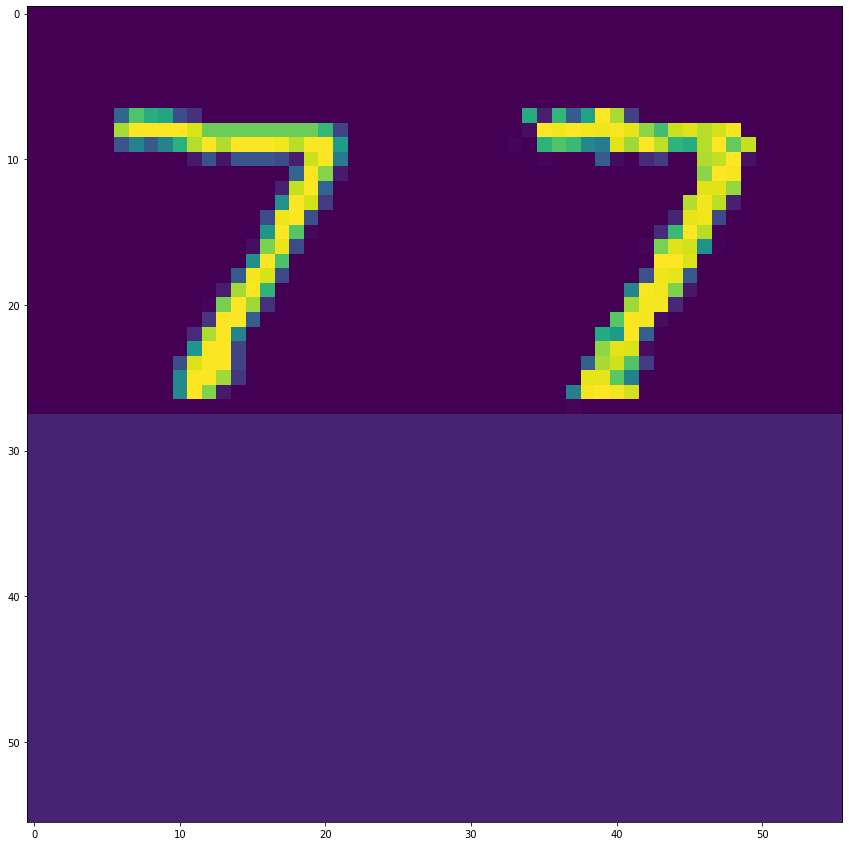

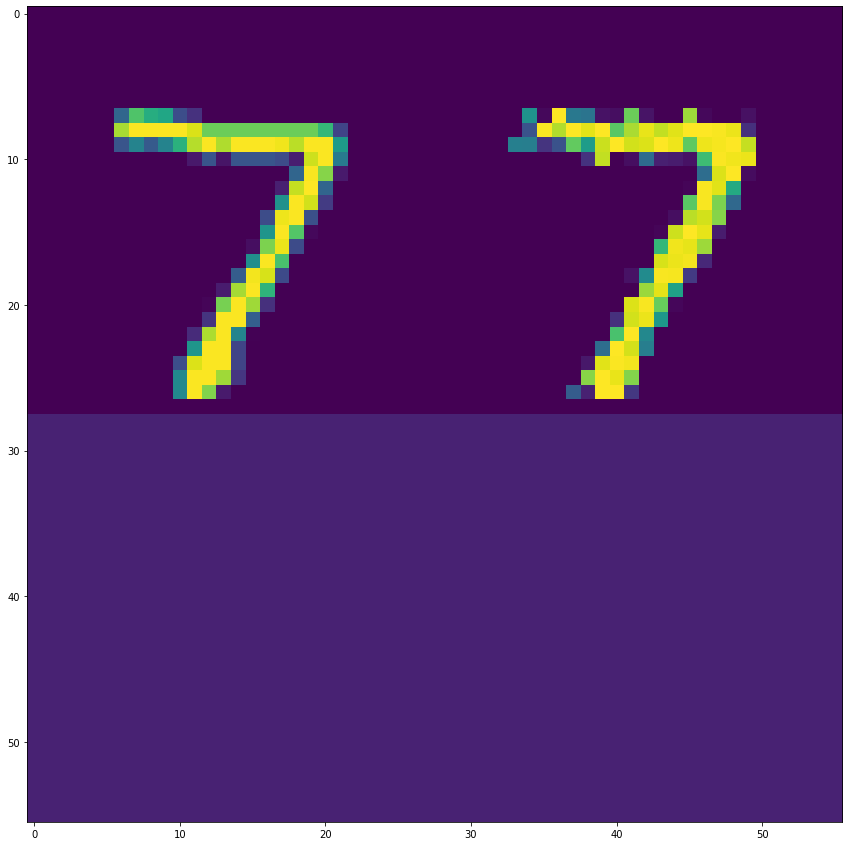

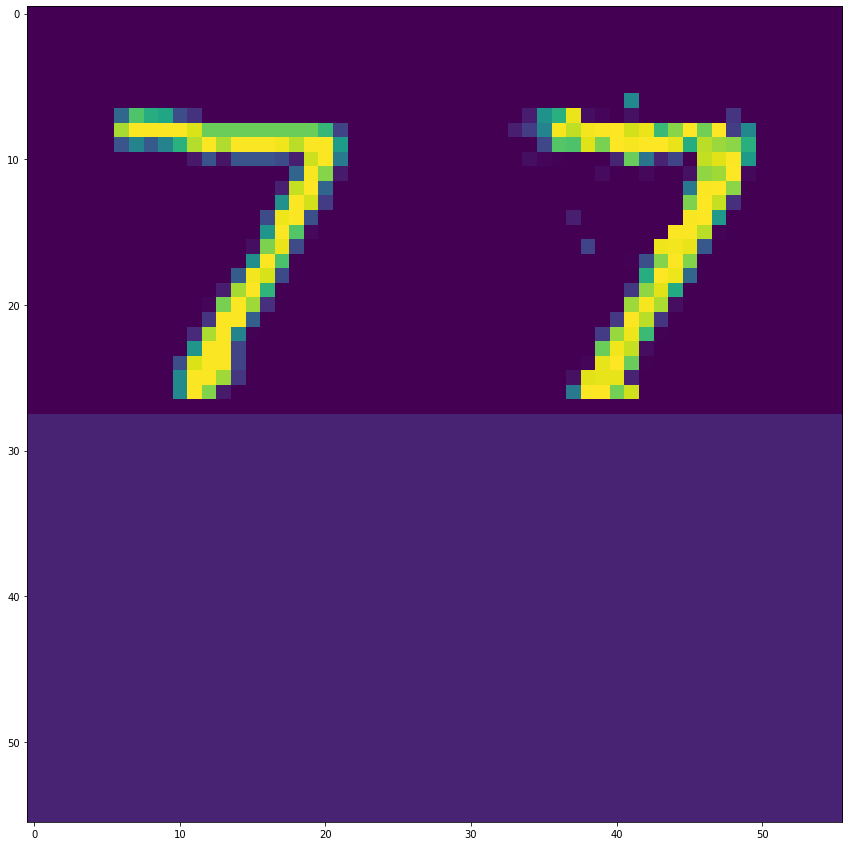

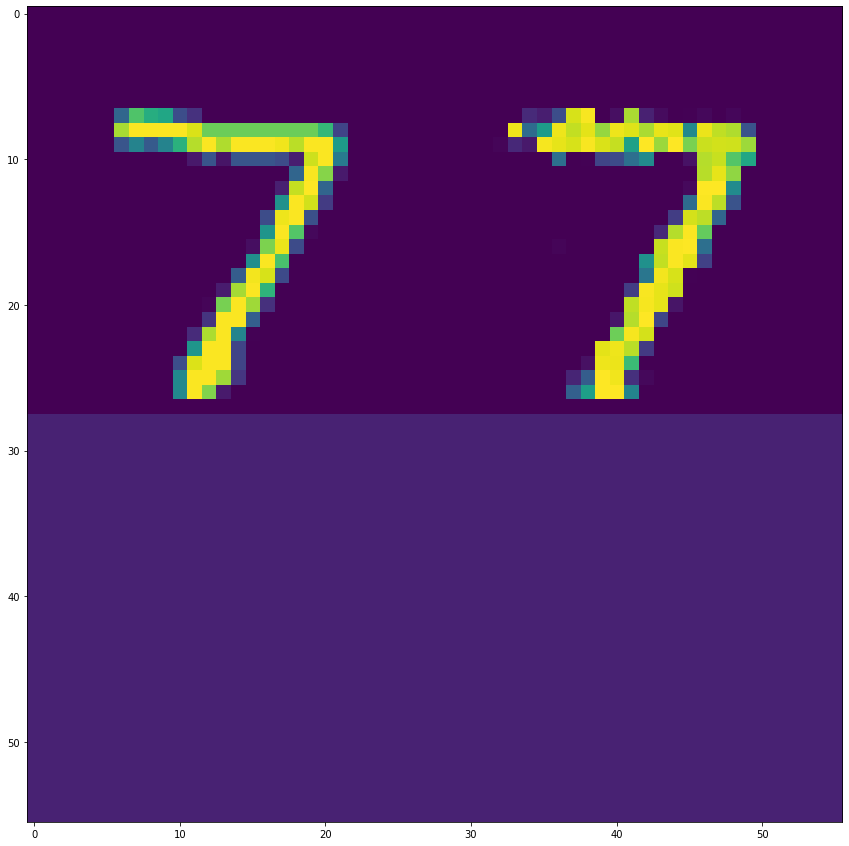

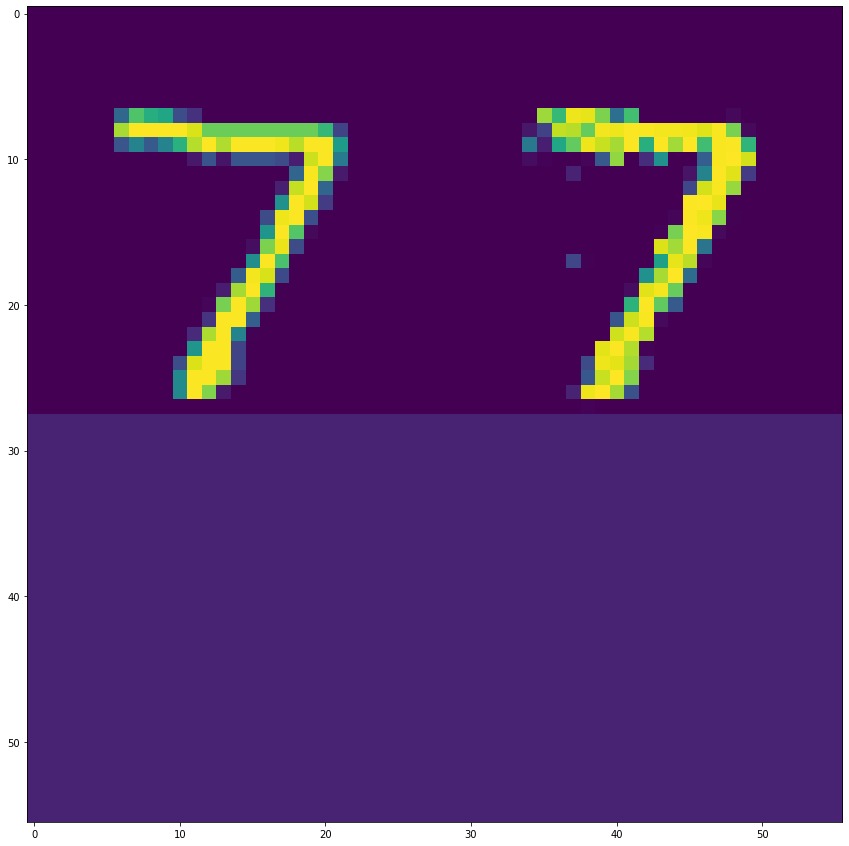

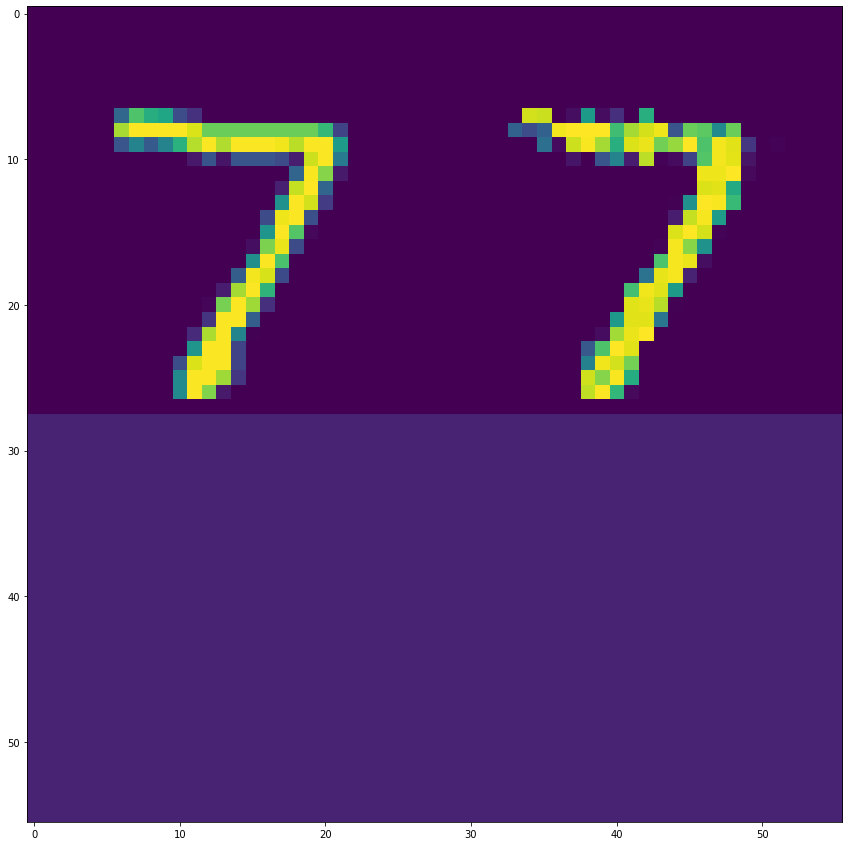

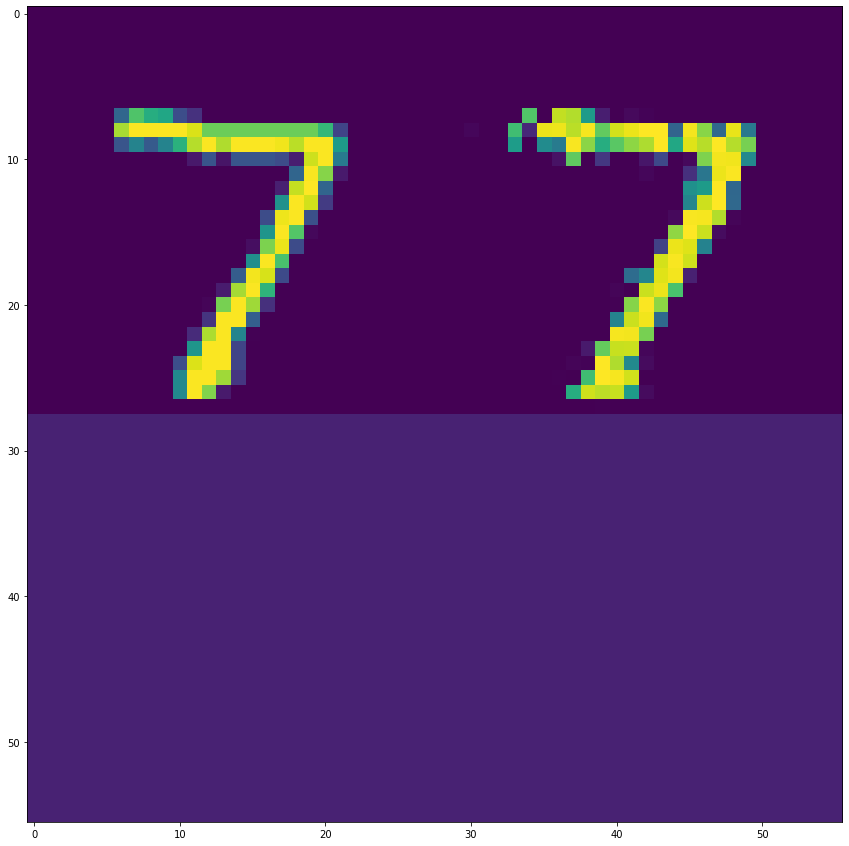

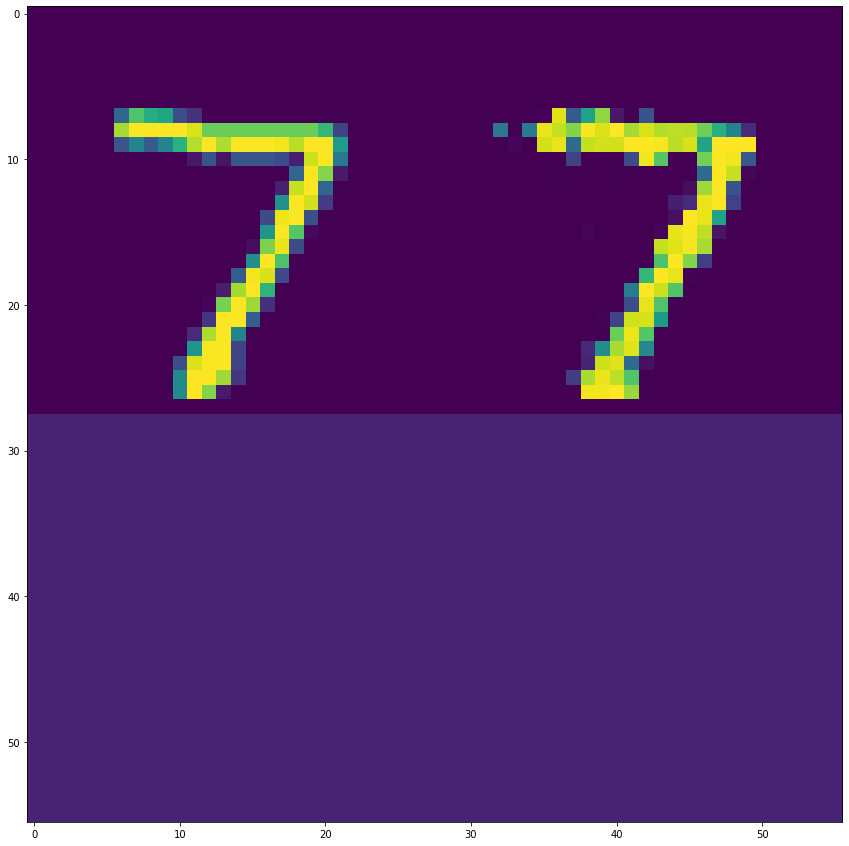

In [22]:
model.eval()
for i in range(10):
    img_reconstruct = model.reconstruct(images[0],device,epoch='last')
    plt.figure(figsize=(15,15))
    plt.imshow(montage(img_reconstruct))

sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior
sampling prior


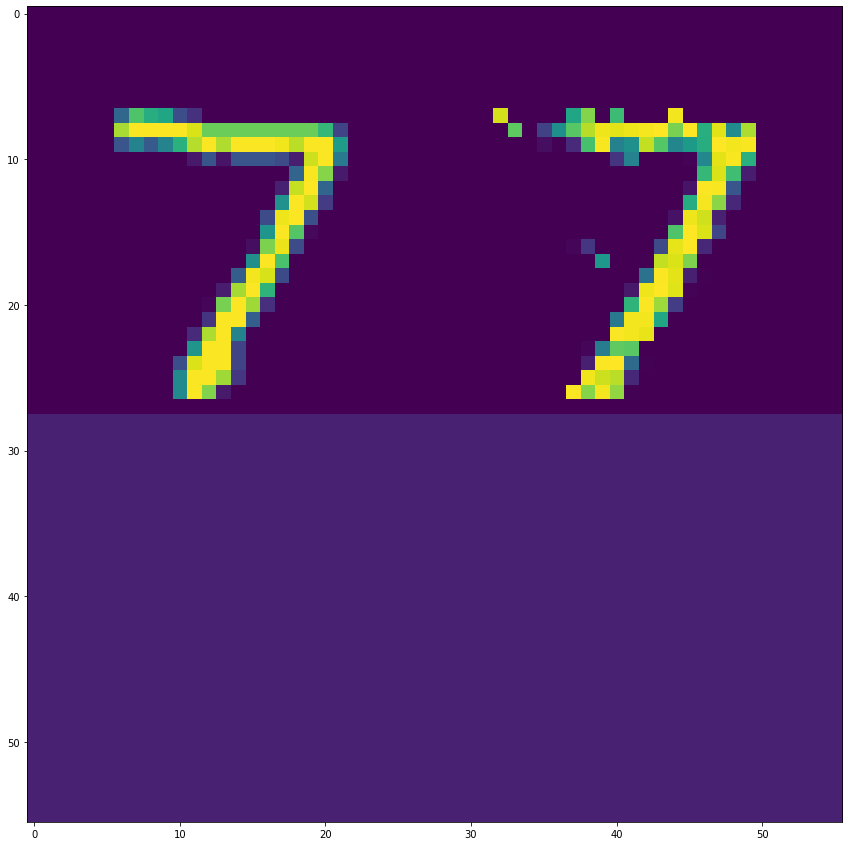

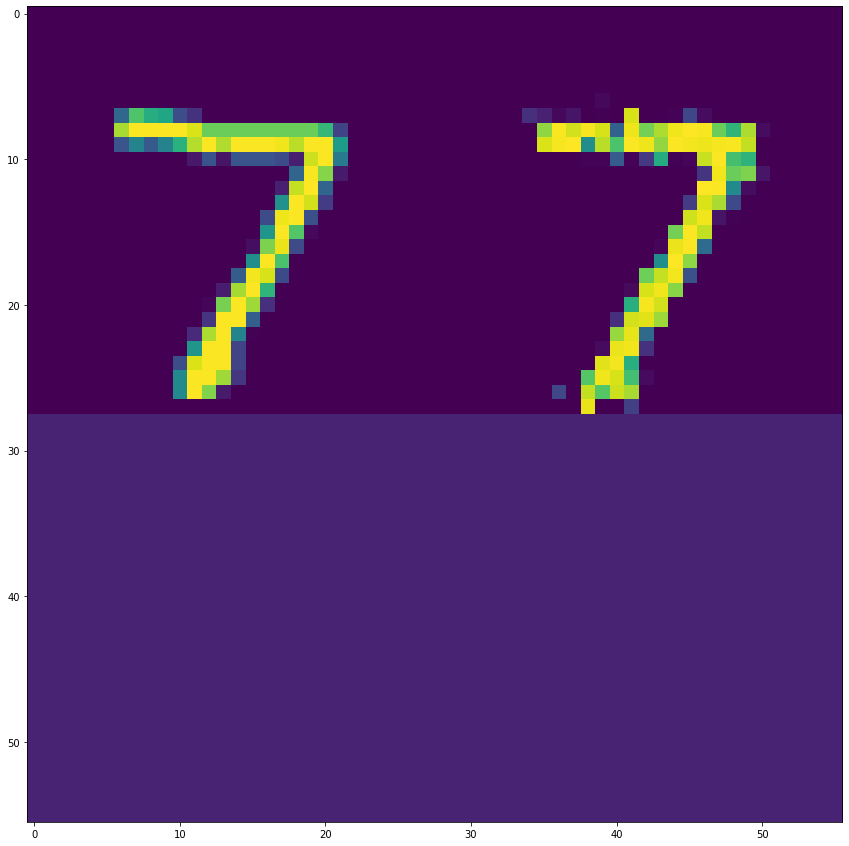

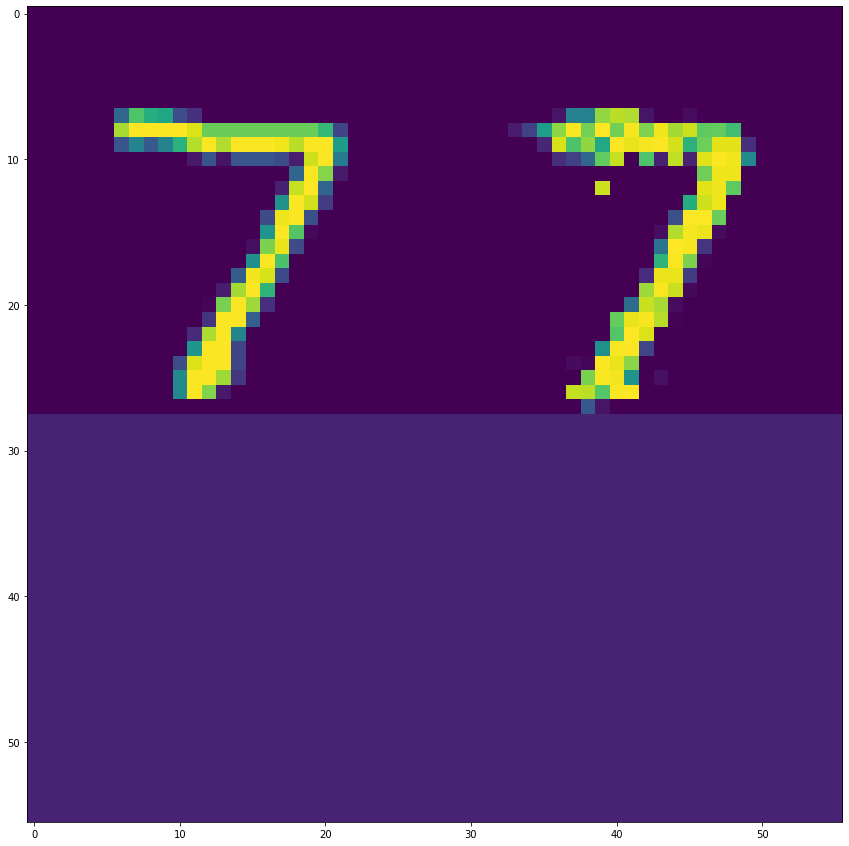

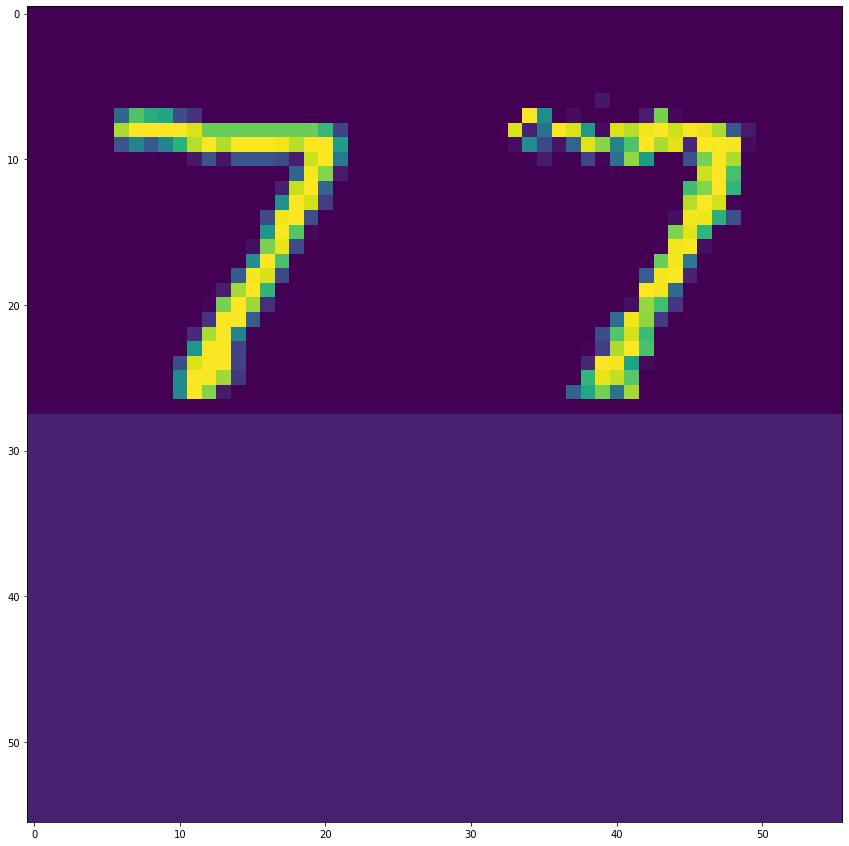

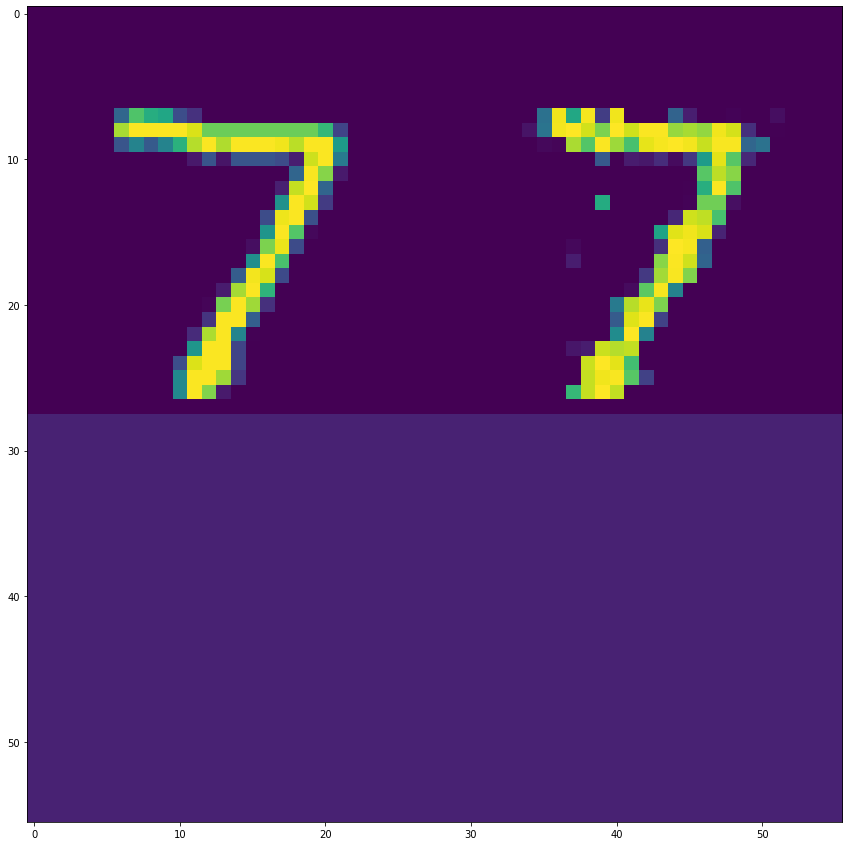

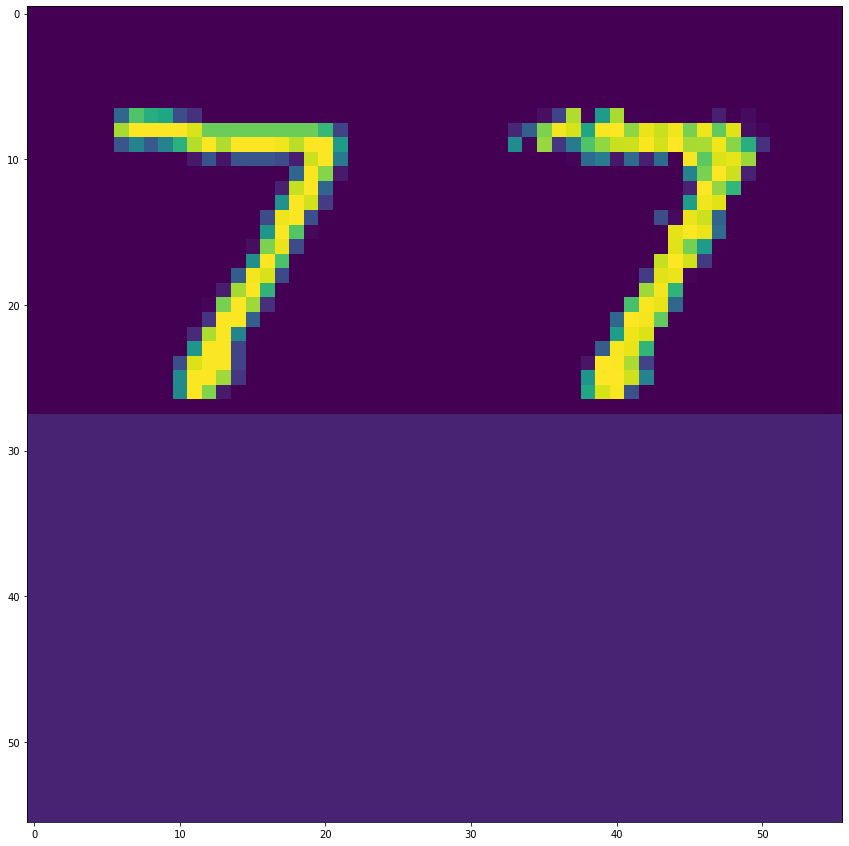

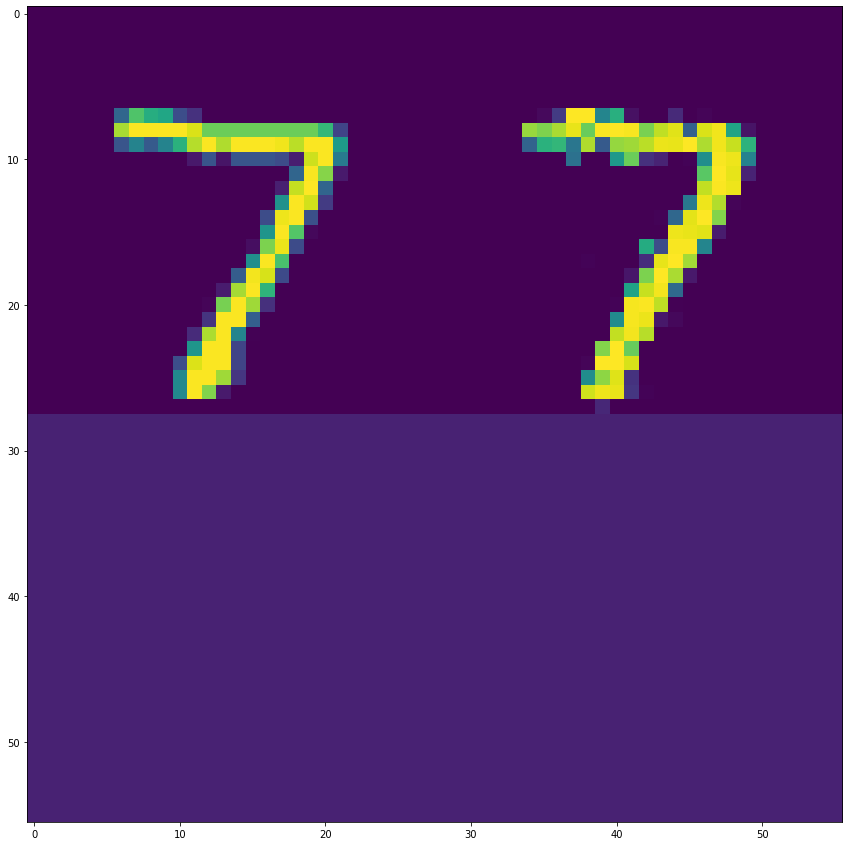

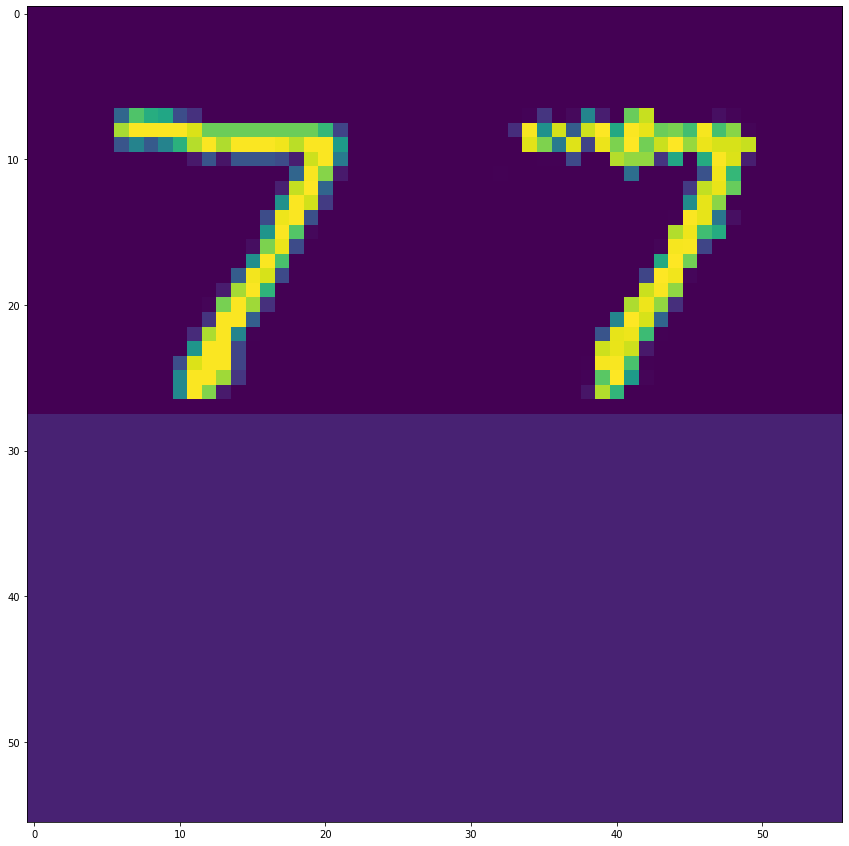

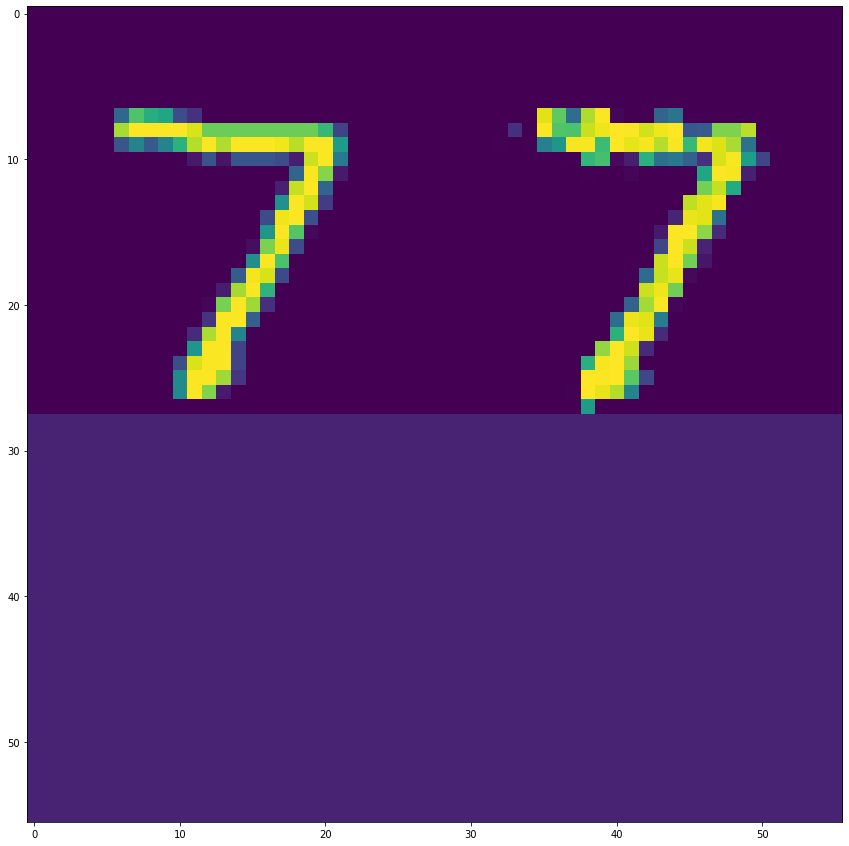

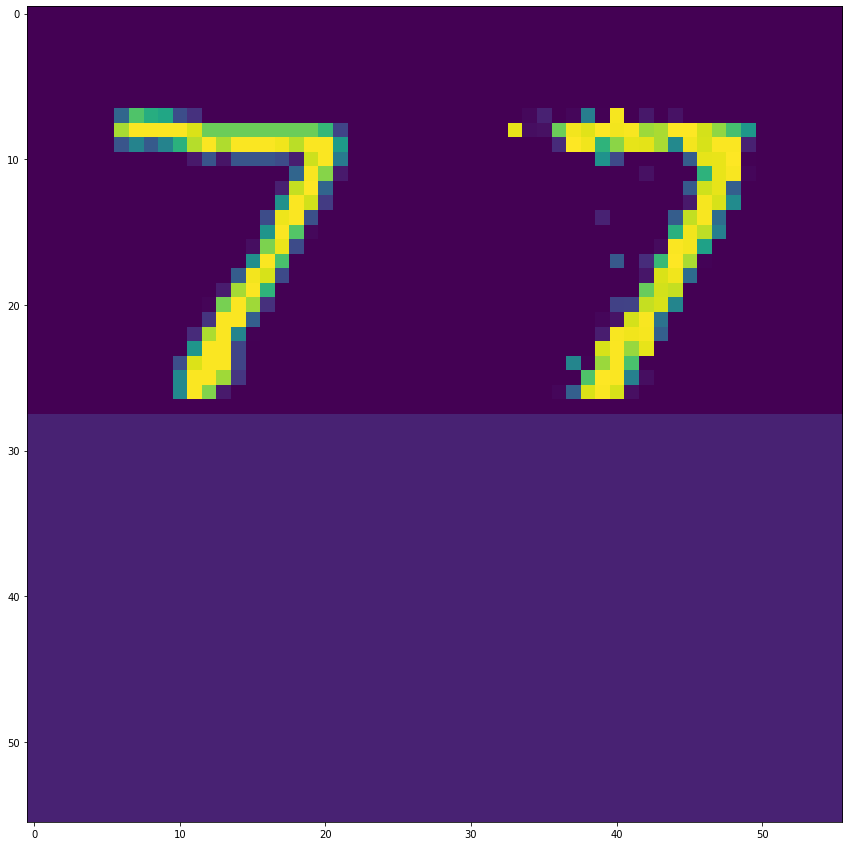

In [23]:
model.sample_prior=True
for i in range(10):
    img_reconstruct = model.reconstruct(images[0],device,epoch='last')
    plt.figure(figsize=(15,15))
    plt.imshow(montage(img_reconstruct))
model.sample_prior=False

In [25]:
x = images[0]
x = x.view(-1, 784).float().to(device)
z_mu, z_logvar = model.encode(x)
z = model.reparameterize(z_mu, z_logvar)  # sample zs

In [26]:
x_alpha, x_beta = model.decode(z)
beta = Beta(x_alpha, x_beta)
p = beta.sample()
binomial = Binomial(255, p)

In [28]:
x_alpha.shape, p.shape

(torch.Size([1, 784]), torch.Size([1, 784]))

In [ ]:
x_recon = binomial.sample()
x_recon = x_recon.float() / 255.

In [ ]:
def beta_binomials_append(a, b, n, precision):
    # TODO: Implement this using bits-back instead of generic discrete distrn.
    print('beta_binomials_append: \nappending the obs_params')
    print('a,b,n,precision:', a[0][:10],b[0][:10],n,precision)
    print('createing beta binomial probabilities from obs_params')
    probs = generate_beta_binomial_probs(a, b, n)
    print(' generate_beta_binomial_probs : ', probs.shape, probs[0][:10])
    return categoricals_append(probs, precision)
def beta_binomial_obs_append(n, precision):
    def obs_append(params):
        
        a, b = params
        def append(state, data):
            
            return beta_binomials_append(a, b, n, precision)(
                state, np.int64(data))
        return append
    return obs_append
def generate_beta_binomial_probs(a, b, n):
    ks = np.arange(n + 1)
    a = a[..., np.newaxis]
    b = b[..., np.newaxis]
    probs = np.exp(beta_binomial_log_pdf(ks, n, a, b))
    # make sure normalised, there are some numerical
    # issues with the exponentiation in the beta binomial
    probs = np.clip(probs, 1e-10, 1.)
    return probs / np.sum(probs, axis=-1, keepdims=True)
def categoricals_append(probs, precision):
    """Assume that the last dim of probs contains the probability vectors,
    i.e. np.sum(probs, axis=-1) == ones"""
    # Flatten all but last dim of probs
    probs = np.reshape(probs, (-1, np.shape(probs)[-1]))
    cdfs = [categorical_cdf(p, precision) for p in probs]
    def append(state, data):
        data = np.ravel(data)
        return non_uniforms_append(precision, cdfs)(state, data)
    return append
def beta_binomial_log_pdf(k, n, a, b):
    a_plus_b = a + b
    numer = (gammaln(n + 1) + gammaln(k + a) + gammaln(n - k + b)
             + gammaln(a_plus_b))
    denom = (gammaln(k + 1) + gammaln(n - k + 1) + gammaln(n + a_plus_b)
             + gammaln(a) + gammaln(b))
    return numer - denom

def create_categorical_buckets(probs, precision):
    buckets = np.rint(probs * ((1 << precision) - len(probs))) + np.ones(probs.shape)
    bucket_sum = sum(buckets)
    if not bucket_sum == 1 << precision:
        i = np.argmax(buckets)
        buckets[i] += (1 << precision) - bucket_sum
    assert sum(buckets) == 1 << precision
    return np.insert(np.cumsum(buckets), 0, 0)  # this could be slightly wrong
def categorical_cdf(probs, precision):
    def cdf(s):
        cumulative_buckets = create_categorical_buckets(probs, precision)
        return int(cumulative_buckets[s])
    return cdf

def categorical_ppf(probs, precision):
    def ppf(cf):
        cumulative_buckets = create_categorical_buckets(probs, precision)
        return np.searchsorted(cumulative_buckets, cf, 'right') - 1
    return ppf

In [19]:
probs=generate_beta_binomial_probs(obs_params[0], obs_params[1], 255)

In [20]:
probs.shape

(1, 784, 256)

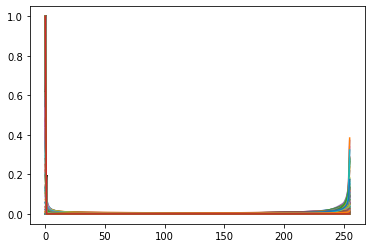

In [21]:
for i in np.arange(784):
    plt.plot(probs[0][i])
plt.show()

<StemContainer object of 3 artists>

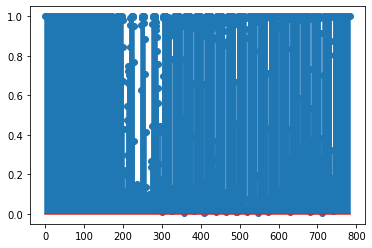

In [22]:
prob_max = [probs[0][i].max() for i in np.arange(784)]
plt.stem(prob_max,use_line_collection=True)

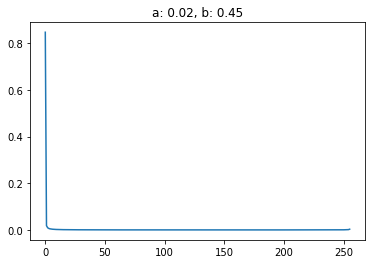

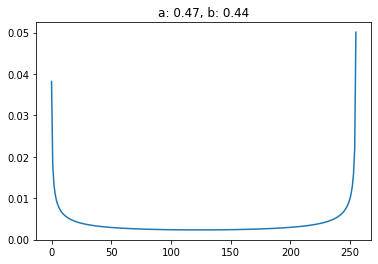

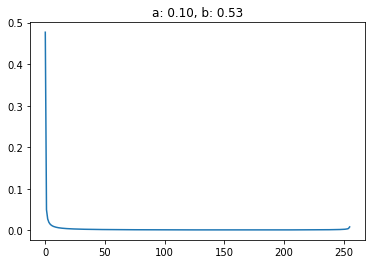

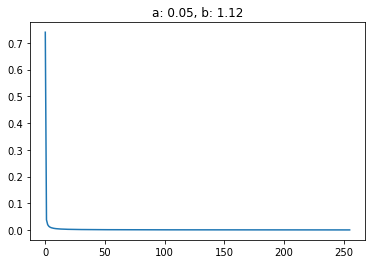

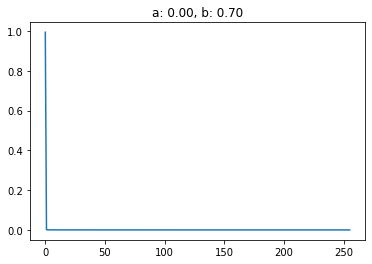

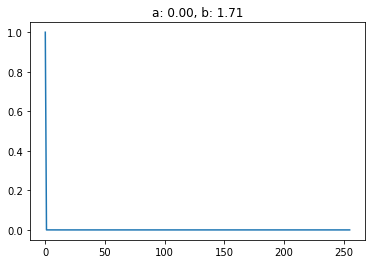

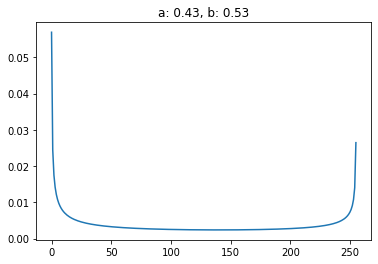

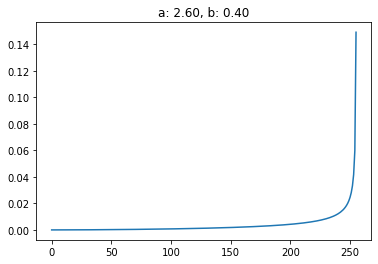

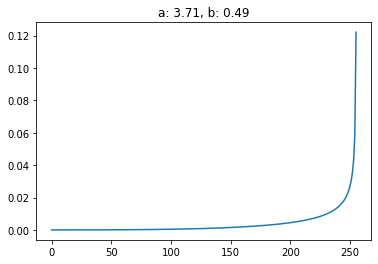

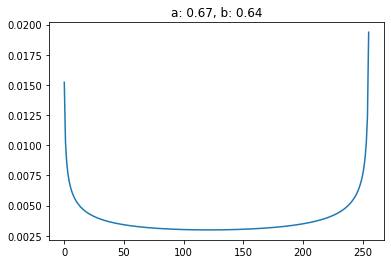

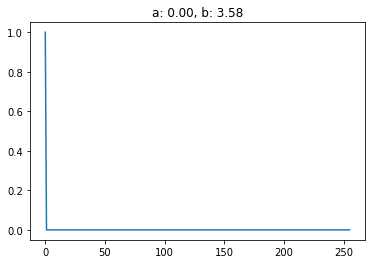

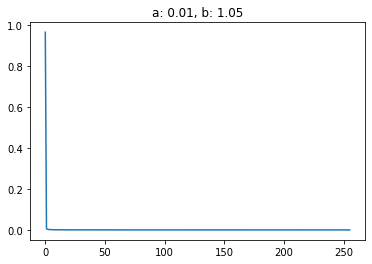

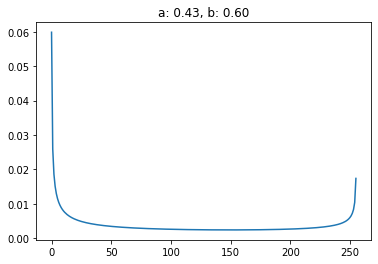

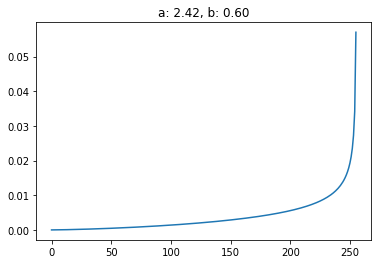

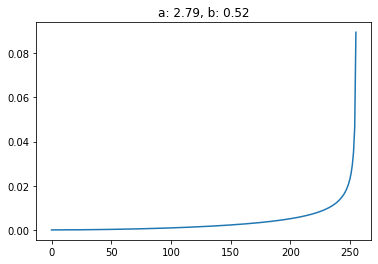

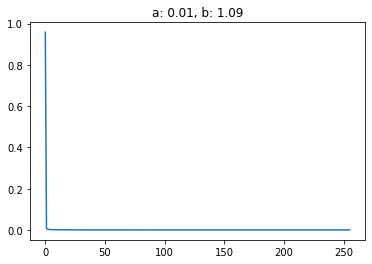

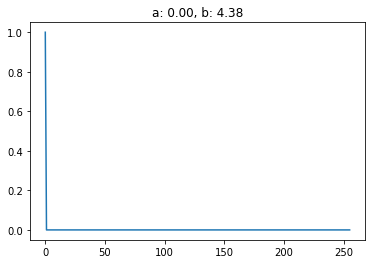

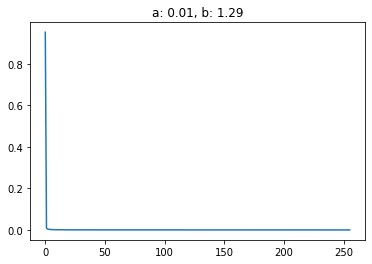

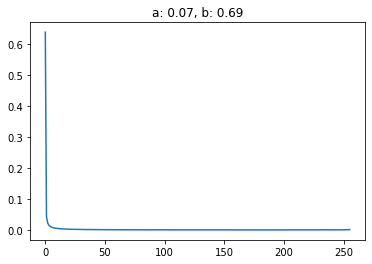

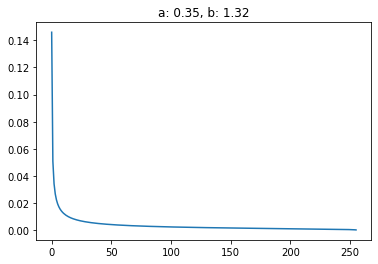

In [23]:
for i in np.arange(200,300,5):
    plt.plot(probs[0][i])
    plt.title('a: {:.2f}, b: {:.2f}'.format(obs_params[0][0][i], obs_params[1][0][i]))
    plt.show()

In [24]:
cdfs = [categorical_cdf(p, obs_precision) for p in probs.squeeze()]

In [90]:
cdf_dist = [cdfs[0](i) for i in range(1<<8)]

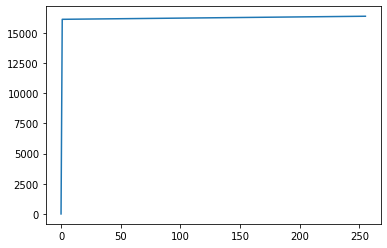

In [91]:
plt.plot(cdf_dist)

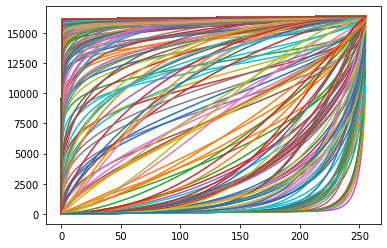

In [92]:
for i_c in range(len(cdfs)):
    cdf_dist = [cdfs[i_c](i) for i in range(1<<8)]
    plt.plot(cdf_dist)
plt.show()

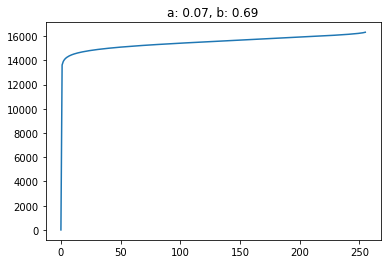

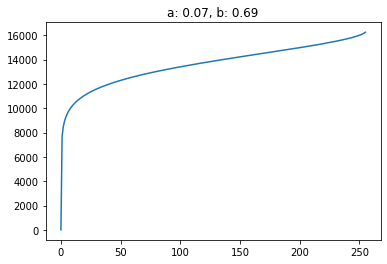

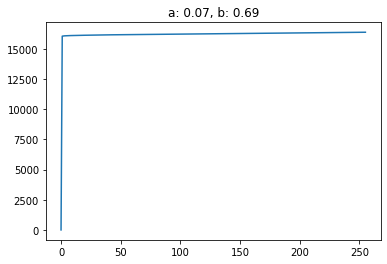

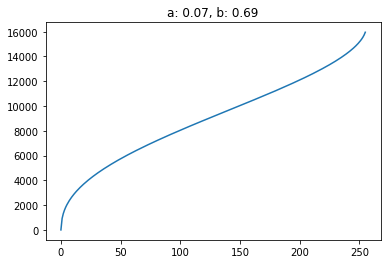

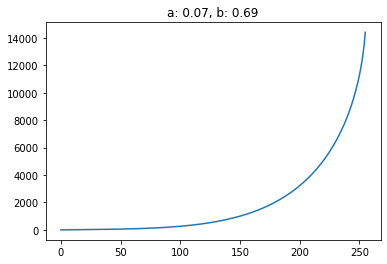

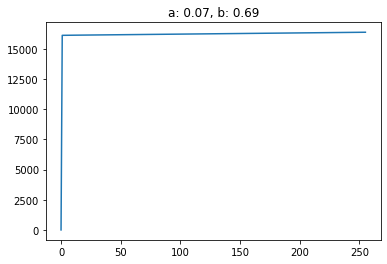

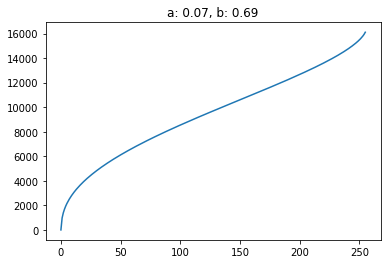

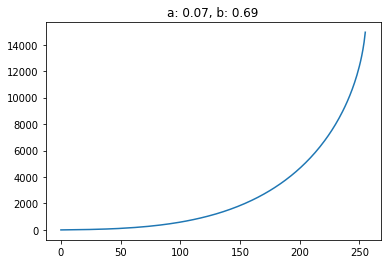

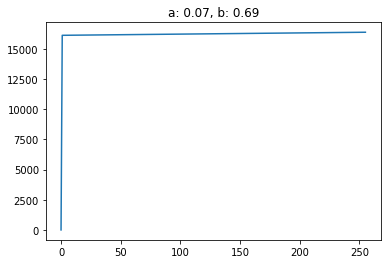

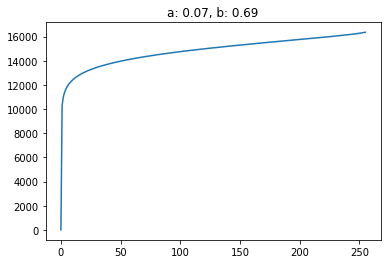

In [94]:
for i_c in np.arange(200,300,10):
    cdf_dist = [cdfs[i_c](i) for i in range(1<<8)]
    plt.plot(cdf_dist)
    plt.title('a: {:.2f}, b: {:.2f}'.format(obs_params[0][0][i], obs_params[1][0][i]))
    plt.show()

In [57]:
state=beta_binomial_obs_append(255,obs_precision)(obs_params)(state,images[0])

beta_binomials_append: 
appending the obs_params
a,b,n,precision: [5.6339463e-06 5.5183723e-06 3.4482971e-06 4.4196054e-06 2.1082838e-06
 2.8835516e-06 3.2802243e-06 6.0380216e-06 3.9311708e-06 3.3856541e-06] [146.9628   236.16246  151.39426  123.27585  126.199554  89.75149
 120.72034  141.3618   111.64987  121.226974] 255 14
createing beta binomial probabilities from obs_params
 generate_beta_binomial_probs :  (1, 784, 256) [[9.99994295e-01 3.58309271e-06 1.13774416e-06 ... 9.99994295e-11
  9.99994295e-11 9.99994295e-11]
 [9.99995929e-01 2.87084246e-06 7.45353608e-07 ... 9.99999689e-11
  9.99999689e-11 9.99999689e-11]
 [9.99996564e-01 2.16903107e-06 6.81186469e-07 ... 1.00005563e-10
  1.00005563e-10 1.00005563e-10]
 ...
 [9.99993737e-01 3.89437187e-06 1.25414838e-06 ... 1.00003272e-10
  1.00003272e-10 1.00003272e-10]
 [9.99995290e-01 2.74178070e-06 9.54909202e-07 ... 9.99995290e-11
  9.99995290e-11 9.99995290e-11]
 [9.99996133e-01 2.30084323e-06 7.80831153e-07 ... 1.00004215e-10
  1.0

img:  1
appending data torch.Size([1, 784])


/home/reasatt/miniconda3/envs/bb/lib/python3.7/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


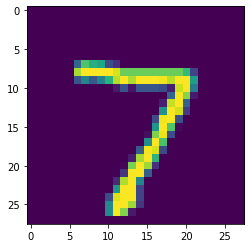

post_pop
non_uni_pop: popped symbols shape (50,)
[175, 192, 128, 11, 208, 254, 60, 244, 210, 70, 100, 252, 98, 222, 220, 178, 255, 174, 243, 44, 75, 244, 233, 85, 160, 207, 72, 182, 191, 103, 180, 180, 156, 215, 144, 101, 114, 126, 151, 83, 101, 246, 74, 52, 97, 27, 46, 88, 209, 36]
lik_append
input latent_idx (50,) [175 192 128  11 208 254  60 244 210  70 100 252  98 222 220 178 255 174
 243  44  75 244 233  85 160 207  72 182 191 103 180 180 156 215 144 101
 114 126 151  83 101 246  74  52  97  27  46  88 209  36]
transformed the latent_idx through a generator to obs_params: 
 2 (1, 784) [3.9360025e-06 4.2631536e-06 2.2446438e-06 3.4886784e-06 1.5844681e-06
 1.8692151e-06 2.4216470e-06 5.0185349e-06 2.6406731e-06 3.0660810e-06]
beta_binomials_append: 
appending the obs_params
a [3.9360025e-06 4.2631536e-06 2.2446438e-06 3.4886784e-06 1.5844681e-06
 1.8692151e-06 2.4216470e-06 5.0185349e-06 2.6406731e-06 3.0660810e-06],
b [150.72165  236.60295  155.4309   141.80083  142.39275  103.119

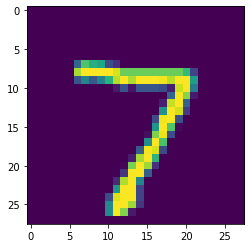

non_uniforms_append input symbols (784,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
prior_append
uniforms_append input symbols (50,)
[175 192 128  11 208 254  60 244 210  70 100 252  98 222 220 178 255 174
 243  44  75 244 233  85 160 207  72 182 191 103 180 180 156 215 144 101
 114 126 151  83 101 246  74  52  97  27  46  88 209  36]
Encoded 0
state len:  79
img:  2
appending data torch.Size([1, 784])


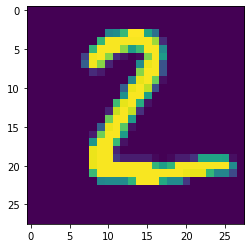

post_pop
non_uni_pop: popped symbols shape (50,)
[195, 89, 224, 157, 191, 226, 3, 26, 219, 20, 176, 67, 49, 126, 53, 186, 52, 29, 231, 22, 254, 14, 23, 201, 63, 239, 24, 221, 146, 35, 39, 205, 124, 198, 223, 84, 103, 28, 29, 57, 185, 17, 64, 248, 2, 188, 27, 103, 199, 98]
lik_append
input latent_idx (50,) [195  89 224 157 191 226   3  26 219  20 176  67  49 126  53 186  52  29
 231  22 254  14  23 201  63 239  24 221 146  35  39 205 124 198 223  84
 103  28  29  57 185  17  64 248   2 188  27 103 199  98]
transformed the latent_idx through a generator to obs_params: 
 2 (1, 784) [3.7356308e-06 2.8188394e-06 3.1600591e-06 3.7988395e-06 2.7989845e-06
 2.6446980e-06 3.1919224e-06 4.6196328e-06 5.8689966e-06 2.0081500e-06]
beta_binomials_append: 
appending the obs_params
a [3.7356308e-06 2.8188394e-06 3.1600591e-06 3.7988395e-06 2.7989845e-06
 2.6446980e-06 3.1919224e-06 4.6196328e-06 5.8689966e-06 2.0081500e-06],
b [106.96963  122.11796  156.00441  167.65395  218.34273  273.30334
 149.093

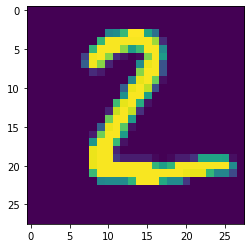

non_uniforms_append input symbols (784,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
prior_append
uniforms_append input symbols (50,)
[195  89 224 157 191 226   3  26 219  20 176  67  49 126  53 186  52  29
 231  22 254  14  23 201  63 239  24 221 146  35  39 205 124 198 223  84
 103  28  29  57 185  17  64 248   2 188  27 103 199  98]
state len:  118

All encoded in 1.05s
Used 2176 bits.
This is 1.39 bits per pixel
uni_pop: popped symbols shape (50,)
[195, 89, 224, 157, 191, 226, 3, 26, 219, 20, 176, 67, 49, 126, 53, 186, 52, 29, 231, 22, 254, 14, 23, 201, 63, 239, 24, 221, 146, 35, 39, 205, 124, 198, 223, 84, 103, 28, 29, 57, 185, 17, 64, 248, 2, 188, 27, 103, 199, 98]
non_uni_pop: popped symbols shape (784,)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
non_uniforms_append input symbols (50,)
[195  89 224 157 191 226   3 

In [4]:
print_interval = 10
encode_start_time = time.time()
for i, image in enumerate(images):
    print('img: ',i+1)
    state = vae_append(state, image)
#     if i==2:
#         break
#     '''
    if not i % print_interval:
        print('Encoded {}'.format(i))
    print('state len: ',len(rans.flatten(state)))
    compressed_length = 32 * (len(rans.flatten(state)) - len(other_bits)) / (i+1)
#     print('compressed_length_avg',compressed_length)
    compress_lengths.append(compressed_length)

print('\nAll encoded in {:.2f}s'.format(time.time() - encode_start_time))
compressed_message = rans.flatten(state)

compressed_bits = 32 * (len(compressed_message) - len(other_bits))
print("Used " + str(compressed_bits) + " bits.")
print('This is {:.2f} bits per pixel'.format(compressed_bits
                                             / (num_images * 784)))

if not os.path.exists('results'):
    os.mkdir('results')
np.savetxt('compressed_lengths_cts', np.array(compress_lengths))

state = rans.unflatten(compressed_message)
decode_start_time = time.time()

for n in range(len(images)):
    state, image_ = vae_pop(state)
    original_image = images[len(images)-n-1].numpy()
    np.testing.assert_allclose(original_image, image_)

    if not n % print_interval:
        print('Decoded {}'.format(n))

print('\nAll decoded in {:.2f}s'.format(time.time() - decode_start_time))

recovered_bits = rans.flatten(state)
assert all(other_bits == recovered_bits)
# '''

In [11]:
image_

tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,  

In [12]:
original_image

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

In [5]:
state

(900731659723581999,
 (924296821,
  (1478675648,
   (441430851,
    (1537430267,
     (192837315,
      (1491500391,
       (1819649033,
        (530767571,
         (626675989,
          (1650972402,
           (1879488292,
            (1277966935,
             (1682717766,
              (243645912,
               (1991481944,
                (1171115404,
                 (1646934330,
                  (2051621569,
                   (1253015014,
                    (1340820007,
                     (124168279,
                      (2061551790,
                       (292314712,
                        (1687063377,
                         (1827989157,
                          (1443512857,
                           (305163085,
                            (1449171016,
                             (374283017,
                              (636458900,
                               (86902899,
                                (1581650896,
                                 (1428656883,
  

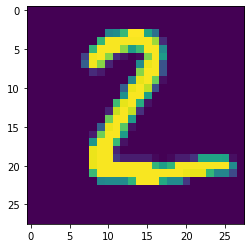

In [6]:
plt.imshow(image.reshape(28,28))

In [7]:
uniform_enc_statfun = lambda s: (s, 1)

In [8]:
uniform_enc_statfun(3)

(3, 1)

In [9]:
uniform_dec_statfun = lambda cf: (cf, (cf, 1))

In [10]:
uniform_dec_statfun(3)

(3, (3, 1))